In [47]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import count, round, concat
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col

spark = SparkSession \
    .builder \
    .appName("RFM") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
df_raw = spark.read.format('com.databricks.spark.csv').\
                           options(header='true', \
                           inferschema='true').\
               load("data/Online Retail.csv",header=True);

In [11]:
# чтобы все spark работали одинаково (версии 2 и 3)
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [3]:
df_raw.show(5)
df_raw.printSchema()

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: stri

In [5]:
# nullable = true - есть пустые значения, проверим сколько их по каждой колонке
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()
    
my_count(df_raw)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|    90995|    90995|      90709|   90995|      90995|    90994|     58567|  90994|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [6]:
df = df_raw.dropna(how='any')
my_count(df)

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|    58567|    58567|      58567|   58567|      58567|    58567|     58567|  58567|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



# RFM - как он есть

In [14]:
# сделаем изменение в колонке InvoiceDate
# из 12/1/10 8:26 => 2010-12-01 08:26

timeFmt = "MM/dd/yy HH:mm"

df = df.withColumn('NewInvoiceDate'
                 , to_utc_timestamp(unix_timestamp(col('InvoiceDate'),timeFmt).cast('timestamp')
                 , 'UTC'))

df.show(5)

+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity| InvoiceDate|UnitPrice|CustomerID|       Country|     NewInvoiceDate|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/10 8:26|     2.55|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/10 8:26|     2.75|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/10 8:26|     3.39|     17850|United Kingdom|2010-12-01 08:26:00|
+---------+---------+-----------

In [18]:
# какую ошибку я тут совершил?

# делаем расчет финальной ценны по позиции (по строке)
df = df.withColumn('TotalPrice', round( df.Quantity * df.UnitPrice, 2 ) )

In [21]:
# здесь какие ошибки?
date_max = df.select(max('NewInvoiceDate')).toPandas()

current = to_utc_timestamp(unix_timestamp(lit(str(date_max.iloc[0][0])), \
                           'yy-MM-dd HH:mm').cast('timestamp'), 'UTC' )

# считаем длительность "жизни" пользователя
# lit - это фиксированое значение, просто current передать нельзя (и число, и строку)
df = df.withColumn('Duration', datediff(lit(current), 'NewInvoiceDate'))

In [23]:
# rfm
recency = df.groupBy('CustomerID').agg(min('Duration').alias('Recency'))

frequency = df.groupBy('CustomerID', 'InvoiceNo').count()\
                        .groupBy('CustomerID')\
                        .agg(count("*").alias("Frequency"))

monetary = df.groupBy('CustomerID').agg(round(sum('TotalPrice'), 2).alias('Monetary'))

rfm = recency.join(frequency,'CustomerID', how = 'inner')\
             .join(monetary,'CustomerID', how = 'inner')

rfm.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     17389|     15|        7|  224.34|
|     13623|      0|        2|   136.1|
|     15727|     34|        2|  2091.6|
|     16503|     33|        3|  831.29|
|     17420|     76|        1|  130.85|
+----------+-------+---------+--------+
only showing top 5 rows



In [26]:
# сделаем сегментацию
cols = ['Recency','Frequency','Monetary']

rfm.select(cols).describe().show()

+-------+------------------+------------------+------------------+
|summary|           Recency|         Frequency|          Monetary|
+-------+------------------+------------------+------------------+
|  count|              1559|              1559|              1559|
|   mean|34.157793457344454| 2.289929441949968| 805.6828864656832|
| stddev|25.192037563824275|2.7880811668997714|2190.3039302976686|
|    min|                 0|                 1|           -1192.2|
|    max|                76|                41|          38370.09|
+-------+------------------+------------------+------------------+



In [40]:
# а где же 25%, 50%, 75% квантили?
# рассчитайте их
rfm.approxQuantile

# вам будет необходим метод approxQuantile
# pandas.DataFrame, .T, указать индекс и столбцы

<bound method DataFrame.approxQuantile of DataFrame[CustomerID: int, Recency: int, Frequency: bigint, Monetary: double]>

In [43]:
# это не идеальное (и точно не лучше решение)
# но вы сможете сделать его лучше. Как?

def RScore(x):
    if  x <= 16:
        return 1
    elif x<= 50:
        return 2
    elif x<= 143:
        return 3
    else:
        return 4

def FScore(x):
    if  x <= 1:
        return 4
    elif x <= 3:
        return 3
    elif x <= 5:
        return 2
    else:
        return 1

def MScore(x):
    if  x <= 293:
        return 4
    elif x <= 648:
        return 3
    elif x <= 1611:
        return 2
    else:
        return 1

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())

In [44]:
rfm_seg = rfm.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+----------+-------+---------+--------+-----+-----+-----+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|
+----------+-------+---------+--------+-----+-----+-----+
|     17389|     15|        7|  224.34|    1|    1|    4|
|     13623|      0|        2|   136.1|    1|    3|    4|
|     15727|     34|        2|  2091.6|    2|    3|    1|
|     16503|     33|        3|  831.29|    2|    3|    2|
|     17420|     76|        1|  130.85|    3|    4|    4|
+----------+-------+---------+--------+-----+-----+-----+
only showing top 5 rows



In [49]:
rfm_seg = rfm_seg.withColumn('RFMScore',
                             concat(col('r_seg'),col('f_seg'), col('m_seg')))
rfm_seg.sort(col('RFMScore')).show(5)

+----------+-------+---------+--------+-----+-----+-----+--------+
|CustomerID|Recency|Frequency|Monetary|r_seg|f_seg|m_seg|RFMScore|
+----------+-------+---------+--------+-----+-----+-----+--------+
|     16839|      7|        6| 2244.95|    1|    1|    1|     111|
|     14085|     12|        7| 1975.16|    1|    1|    1|     111|
|     14180|      8|       12| 1678.42|    1|    1|    1|     111|
|     12471|      4|       13| 4967.06|    1|    1|    1|     111|
|     17677|      4|        8| 2718.35|    1|    1|    1|     111|
+----------+-------+---------+--------+-----+-----+-----+--------+
only showing top 5 rows



In [51]:
# статистический результат
rfm_seg.groupBy('RFMScore')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} )\
        .sort(col('RFMScore')).show(5)

+--------+-----------------+------------------+------------------+
|RFMScore|     avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+--------+-----------------+------------------+------------------+
|     111|5.944444444444445| 7181.969074074074| 11.25925925925926|
|     112|6.142857142857143|1159.4153571428571| 7.464285714285714|
|     113|              9.4|           462.754|               6.6|
|     114|              9.5|150.95000000000002|               7.5|
|     121|5.913043478260869|2953.4104347826087|4.3478260869565215|
+--------+-----------------+------------------+------------------+
only showing top 5 rows



# Сделаем кластеризацию (RFM, но K-Means)

In [76]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from pyspark.ml.clustering import KMeans
from functools import reduce  # For Python 3.x
from pyspark.ml.evaluation import ClusteringEvaluator

# создаем матрицу фичей
def transData(data):
    return data.rdd.map(lambda r: [r[0],Vectors.dense(r[1:])]).toDF(['CustomerID','rfm'])

In [59]:
transformed= transData(rfm)
transformed.show(5)

+----------+-----------------+
|CustomerID|              rfm|
+----------+-----------------+
|     17389|[15.0,7.0,224.34]|
|     13623|  [0.0,2.0,136.1]|
|     15727|[34.0,2.0,2091.6]|
|     16503|[33.0,3.0,831.29]|
|     17420|[76.0,1.0,130.85]|
+----------+-----------------+
only showing top 5 rows



In [60]:
# скалируем все наши фичи
scaler = MinMaxScaler(inputCol="rfm",\
                      outputCol="features")

scalerModel =  scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)
scaledData.show(5,False)

+----------+-----------------+-------------------------------------------------------------+
|CustomerID|rfm              |features                                                     |
+----------+-----------------+-------------------------------------------------------------+
|17389     |[15.0,7.0,224.34]|[0.19736842105263158,0.15000000000000002,0.03580530854002638]|
|13623     |[0.0,2.0,136.1]  |[0.0,0.025,0.03357490175619258]                              |
|15727     |[34.0,2.0,2091.6]|[0.4473684210526315,0.025,0.08300328418804878]               |
|16503     |[33.0,3.0,831.29]|[0.43421052631578944,0.05,0.05114693815752324]               |
|17420     |[76.0,1.0,130.85]|[1.0,0.0,0.033442199630001196]                               |
+----------+-----------------+-------------------------------------------------------------+
only showing top 5 rows



In [83]:
predictions

DataFrame[CustomerID: bigint, rfm: vector, features: vector, cluster: int]

In [91]:
import numpy as np

n_rounds = 4
cost = np.zeros(n_rounds)
for k in range(2,n_rounds):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("features")\
            .setPredictionCol("prediction")

    model = kmeans.fit(scaledData)

    predictions = model.transform(scaledData)    
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    cost[k] = silhouette
    print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.8383159513178675
Silhouette with squared euclidean distance = 0.7304459590331249


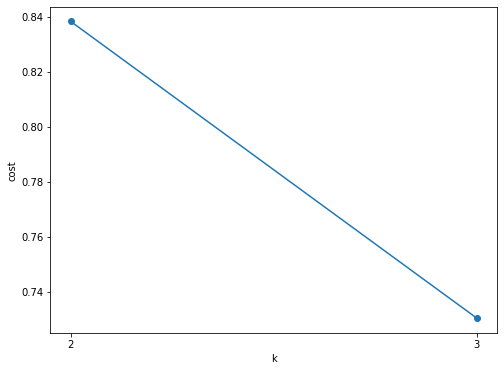

In [92]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,n_rounds),cost[2:n_rounds], marker = "o")
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [73]:
# выбираем лучшее количество
k = 3
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(scaledData)

predictions = model.transform(scaledData)
predictions.show(5,False)

+----------+-----------------+-------------------------------------------------------------+----------+
|CustomerID|rfm              |features                                                     |prediction|
+----------+-----------------+-------------------------------------------------------------+----------+
|17389     |[15.0,7.0,224.34]|[0.19736842105263158,0.15000000000000002,0.03580530854002638]|1         |
|13623     |[0.0,2.0,136.1]  |[0.0,0.025,0.03357490175619258]                              |1         |
|15727     |[34.0,2.0,2091.6]|[0.4473684210526315,0.025,0.08300328418804878]               |0         |
|16503     |[33.0,3.0,831.29]|[0.43421052631578944,0.05,0.05114693815752324]               |0         |
|17420     |[76.0,1.0,130.85]|[1.0,0.0,0.033442199630001196]                               |2         |
+----------+-----------------+-------------------------------------------------------------+----------+
only showing top 5 rows



In [93]:
# делаем предикты
results = rfm.join(predictions.select('CustomerID','prediction'),'CustomerID',how='left')
results.show(5)

+----------+-------+---------+--------+----------+
|CustomerID|Recency|Frequency|Monetary|prediction|
+----------+-------+---------+--------+----------+
|     13098|      4|        5|  804.35|         1|
|     15057|     18|        1|  1131.0|         1|
|     15194|     15|        7| 2143.31|         1|
|     17048|     25|        2|  250.91|         0|
|     12967|      5|        3| 1630.95|         1|
+----------+-------+---------+--------+----------+
only showing top 5 rows



In [95]:
results.groupBy('prediction')\
       .agg({'Recency':'mean',
             'Frequency': 'mean',
             'Monetary': 'mean'} )\
        .sort(col('prediction')).show(5)

+----------+-----------------+------------------+------------------+
|prediction|     avg(Recency)|     avg(Monetary)|    avg(Frequency)|
+----------+-----------------+------------------+------------------+
|         0|29.15320910973085| 611.2591304347822|1.8426501035196687|
|         1|8.608540925266905|1407.1154448398572|3.5106761565836297|
|         2|66.79571984435798| 330.7832295719843|1.3754863813229572|
+----------+-----------------+------------------+------------------+

